# Sub Net

In [51]:
import socket, os
import numpy as np
from tensorflow.keras import layers as KL
from tqdm import tqdm
import glob, copy
import scipy
from tensorflow import keras
import tensorflow as tf
from tensorflow.keras import backend as K
import sys
# from freesurfer import deeplearn as fsd
import freesurfer as fs
from freesurfer.lookups import nonlateral_aseg_recoder

import neurite as ne
import neurite_sandbox as nes
import voxelmorph as vxm
import voxelmorph_sandbox as vxms
from pathlib import Path
from tensorflow.keras.utils import to_categorical
import surfa as sf
from utils import *

import layer_dict as ld
import pdb as gdb

from tensorflow.keras.optimizers import Adam


log_dir = "logs"
models_dir = "models_nfeats_114"

initial_epoch = 90
checkpoint_path=models_dir+'/weights_epoch_'+str(initial_epoch)+'.h5'

if not os.path.exists(log_dir):
    os.makedirs(log_dir)

if not os.path.exists(models_dir):
    os.makedirs(models_dir)
    
weights_saver = PeriodicWeightsSaver(filepath=models_dir, save_freq=10)  # Save weights every 100 epochs

TB_callback = CustomTensorBoard(
    base_log_dir=log_dir,
    histogram_freq=100,
    write_graph=True,
    write_images=False,
    write_steps_per_second=False,
    update_freq='epoch',
    profile_batch=0,
    embeddings_freq=0,
    embeddings_metadata=None
)
            
vscale = 2
vscale = 1

dofit = False

which_loss = 'both'
which_loss = 'mse'
which_loss = 'cce'
which_loss = 'dice'

same_contrast=False
same_contrast=True

oshapes = False
oshapes = True

fit_lin = True
fit_lin = False

save_model = False
save_model = True

doaff = False
doaff = True

test_adni = False


model_dir = 'models'
gpuid = -1
host = socket.gethostname()
from neurite_sandbox.tf.utils.utils import plot_fit_callback as pfc


print(f'host name {socket.gethostname()}')
# print("visible devices:", os.environ["CUDA_VISIBLE_DEVICES"])
# ngpus = 1 if os.getenv('NGPUS') is None else int(os.getenv('NGPUS'))
from tensorflow.python.client import device_lib

local_device_protos = device_lib.list_local_devices()
ngpus = len([x.name for x in local_device_protos if x.device_type == 'GPU'])
# ngpus =len(os.environ["CUDA_VISIBLE_DEVICES"])
print(f'using {ngpus} gpus')
if ngpus > 1:
    model_device = '/gpu:0'
    synth_device = '/gpu:1'
    synth_gpu = 1
    dev_str = "0, 1"
else:
    model_device = '/gpu:0'
    synth_device = model_device
    synth_gpu = 0
    dev_str = "0"
os.environ["CUDA_VISIBLE_DEVICES"] = dev_str
print(f'model_device {model_device}, synth_device {synth_device}, dev_str {dev_str}')
print(f'physical GPU # is {os.getenv("SLURM_STEP_GPUS")}')
ret = ne.utils.setup_device(dev_str)


host name rtx-08.nmr.mgh.harvard.edu
using 0 gpus
model_device /gpu:0, synth_device /gpu:0, dev_str 0
physical GPU # is None


In [68]:
import linecache
import os, psutil
from itertools import islice

ntest = 5
num_subjects=10

print(f'dofit {dofit}, doaff {doaff}, fit_lin {fit_lin}, oshapes {oshapes}, save_model {save_model}')


batch_size = 1

adir = '/autofs/cluster/freesurfer/subjects/atlases/aseg_atlas'
mname = 'seg_edited.mgz'
vname = 'norm.mgz'
sfile = os.path.join(adir, 'scripts', 'subjects.txt')

# man_subjects = [linecache.getline(sfile, i).strip() for i in range(1, num_subjects + 1)]
man_subjects = [line.strip() for line in islice(open(sfile), num_subjects)]


crop = -1 if dofit else ntest
crop=20

odir = '/autofs/vast/braindev/braindev/OASIS/OASIS1/synth-high-res/recon_subject'
subjects = [f for f in Path(odir).iterdir() if 'OASIS_OAS1_0' in str(f)]

print(len(subjects))

seg_files = [f / 'mri/aparc+aseg.mgz' for f in tqdm(subjects[0:crop])]

print(len(seg_files),len(subjects))
if dofit:
    print(f'TRAINING model with loss {which_loss}')
else:
    print(f'loading model trained with {which_loss} loss')

target_shape = (192,)*3
inshape = target_shape



lut = fs.lookups.default()

lesion_label_orig = lut.search('Left-Lesion')
if len(lesion_label_orig) > 0:
    lesion_label_orig = lesion_label_orig[0]
else:   # not in the lut - add a new one
    lesion_label_orig = 77
    lut.add(lesion_label_orig, 'Lesion', color=[240,240,240])

if 'inited' not in locals() and 'inited' not in globals():
    inited = False

# print("lut:",lut)

if not inited:
    # mri_segs_orig = [fs.Volume.read(str(fname)) for fname in tqdm(seg_files[:crop])]
    mri_segs_orig = [sf.load_volume(str(fname)) for fname in tqdm(seg_files[:crop])]

    # mri_segs = [sf.load_volume(str(fname)) for fname in tqdm(seg_files[:crop])]
    if vscale > 1:
        print(f'downsampling by {vscale}')
        mri_segs = [mri.reslice(vscale) for mri in tqdm(mri_segs_orig)]
    else:
        print(f'cropping to {target_shape}')
        mri_segs = [mri.fit_to_shape(target_shape, center='bbox') for mri in tqdm(mri_segs_orig)]
        # mri_segs = [mri.reshape(target_shape, center='bbox') for mri in tqdm(mri_segs)]

    np_segs_orig = [mri.data for mri in mri_segs]
    print(f'finding unique labels in {len(mri_segs_orig)} datasets...')
    labels_orig = np.unique(np.array(np_segs_orig))
    print("labels orig:",labels_orig)
    # mapping = fs.lookups.tissue_type_recoder_no_skull(include_lesions=use_lesions)
    mapping = fs.lookups.nonlateral_aseg_recoder()
    target_lut = mapping.target_lut
    print("target_lut: ",target_lut)
    lut_name = 'nonlat.txt'
    mri_segs_recoded = [fs.label.recode(mri, mapping) for mri in mri_segs]  
    print("mri_segs_recoded: ", mri_segs_recoded[0].shape,np.max(mri_segs_recoded[0]))
    lesion_label = target_lut.search('Left-Lesion')[0]
    print("lesion_label:",lesion_label)
    np_segs = [vol.data for vol in mri_segs_recoded]
    print("vol:", mri_segs_recoded[0].shape)
    labels_in = np.unique(np.array(np_segs)).astype(int)
    print("labels in: ", labels_in)
    if lesion_label not in labels_in:
        l = list(labels_in)
        l.append(lesion_label)
        labels_in = np.array(l)
    nlabels_small = len(labels_in)
    label_map = {}
    keys = mapping.mapping.keys()
    # print("keys:",keys)
    lab_to_ind = np.zeros((labels_orig.max()+1,), dtype=np.uint8)
    for label in labels_orig:
        if label not in keys:
            output_label = 0
        else:
            output_label = mapping.mapping[label]
        label_map[label] = output_label
        lab_to_ind[label] = output_label


    mri_man_segs = []  # manual segs
    mri_norms = []  # mri vols
    mri_norms_orig = []
    mri_man_segs_orig = []

    mri_seg_atlas = sf.load_volume("aseg_atlas.mgz").reshape(target_shape)
    print("mri_seg_atlas:",mri_seg_atlas.shape)
    hard_seg = np.argmax(mri_seg_atlas.data, axis=-1)
    mri_hard_seg = mri_seg_atlas.copy()
    mri_hard_seg.data = hard_seg
    mri_hard_seg_cropped = mri_hard_seg.reshape(target_shape)
    print(mri_hard_seg_cropped.shape)
    mri_norm_atlas = sf.load_volume("norm_atlas.mgz").resample_like(mri_hard_seg)
    print("mri_norm_atlas:",mri_norm_atlas.shape)
    # mri_hard_seg = mri_seg_atlas.copy(hard_seg).fit_to_shape(target_shape, center='bbox')
    # mri_norm_atlas = fs.Volume.read("norm_atlas.mgz").resample_like(mri_hard_seg)

    mri_seg_atlas = mri_seg_atlas.resample_like(mri_hard_seg)
    norm_atlas = (mri_norm_atlas.data / mri_norm_atlas.data.max())[np.newaxis, ..., np.newaxis]
    print("norm atlas shape: ", norm_atlas.shape,mri_hard_seg.shape,mri_seg_atlas.shape)
    inited = True
warp_max=2.5
warp_max=2.1
warp_max=2   
warp_min=.5
warp_blur_min=np.array([2, 4, 8])
warp_blur_max=warp_blur_min*2
bias_blur_min=np.array([2, 4, 8])
bias_blur_max=bias_blur_min*2

fscale = 1
fscale = 1.75
fscale = 1.5   # matches P32 N 16
fscale = 1.1
# nfeats = 100
nfeats = 42
nsmall = 0
nb_levels = int(np.log2(inshape[0]))-(1+nsmall)   # 4,4,4 is lowest level
nb_conv_per_level = 2
unet_scale = 1
nfeats_small = int(nfeats // 3)
unet_nf = []


print(f'using warp max = {warp_max} and nlabels {nlabels_small}, fscale {fscale}')
inshape=np_segs[0].shape
gen_args = dict(
    warp_min=warp_min,
    warp_max=warp_max,
    blur_max=2,  # was .5, then 1
    bias_max=.25,  # was 2 then .5
    bias_blur_min=bias_blur_min,
    bias_blur_max=bias_blur_max,
    gamma=0,
    # warp_zero_mean=True,
    zero_background=.75,
    noise_max=.2,   
    noise_min=.1
)


for level in range(nb_levels-nsmall):
    filters_in_this_level = []
    for layer in range(nb_conv_per_level):
        filters_in_this_level.append(int(fscale**level*nfeats))
        
    unet_nf.append(filters_in_this_level)

print("len unet_nf",len(unet_nf), unet_nf)
unet_nf = [[nfeats_small] * nb_conv_per_level] * nsmall + unet_nf

unet_nf


dofit False, doaff True, fit_lin False, oshapes True, save_model True
415


100%|██████████| 20/20 [00:00<00:00, 130257.89it/s]

20 415
loading model trained with dice loss
using warp max = 2 and nlabels 17, fscale 1.1
len unet_nf 6 [[60, 60], [66, 66], [72, 72], [79, 79], [87, 87], [96, 96]]


[[60, 60], [66, 66], [72, 72], [79, 79], [87, 87], [96, 96]]

# Section 2

In [69]:
import generators as gens

tf.compat.v1.enable_eager_execution()

lr = 1e-5
lr = 1e-4
lr_lin = 1e-4
thresh = -.2*2 
cooldown = 25
patience = 600

name = f'aseg.outside.unet_nf.{nfeats}.{nfeats_small}.{nsmall}.levels.{nb_levels}.warp_max.{warp_max}.oshapes.{oshapes}.fscale.{fscale}'

label_weights = np.ones((1,nlabels_small,))
# label_weights[0,-1] = .01  # downweight lesion class
lfunc = ne.losses.Dice(nb_labels=nlabels_small, weights=None, check_input_limits=False).mean_loss


unet_device = model_device if (fit_lin or dofit) else synth_device
with tf.device(unet_device): 
    model_lin = ne.models.unet(unet_nf, inshape+(1,), None, 3, nlabels_small, feat_mult=None, final_pred_activation='linear')
    print(f'unet model created with nf {unet_nf}')
    softmax_out = KL.Softmax(name='seg')(model_lin.outputs[0])
    model = tf.keras.Model(model_lin.inputs, [softmax_out])
    model.summary()

vxm_model = gens.read_vxm_model(inshape)
vxm_smooth_wt = np.zeros((1, 1))
vxm_smooth_wt[0,0] = .3   # warp regularization hyper parameter

gen_model = gens.create_gen_model(np_segs, oshapes, synth_device, nlabels_small, labels_in, inshape, warp_max)

if fit_lin and dofit:
    thresh_lin = 5
    thresh = -.5
    print(f'thresh {thresh}, thresh_lin {thresh_lin}')
    lr_cb_lin = nes.tf.callbacks.ReduceLRWithModelCheckpointAndRecovery(name+'.lin.h5', monitor='loss',
                                                                        verbose=1, cooldown=cooldown, 
                                                                        recovery_decrease_factor=.8,
                                                                        factor=.8, patience=patience, 
                                                                        thresh_increase_factor=2,
                                                                        thresh=thresh_lin,
                                                                        save_weights_only=True, 
                                                                        burn_in=10,
                                                                        min_lr=1e-7,
                                                                        warm_restart_epoch=None,
                                                                        nloss=5,
                                                                        warm_restart_lr=None)

    callbacks_lin = [lr_cb_lin, write_cb_lin, ne.callbacks.LRLog(), mc_cb_lin]
    callbacks_lin = [lr_cb_lin, write_cb_lin, ne.callbacks.LRLog()]
    lfunc_lin = ne.losses.MeanSquaredErrorProb().loss
    with tf.device(synth_device):
        gen_lin = synth_gen(mri_segs_recoded, gen_model, None, labels_in, batch_size=batch_size, 
                            use_rand=True, gpuid=synth_gpu,use_log=True, add_outside=oshapes)
        gen = synth_gen(mri_segs_recoded, gen_model, None, labels_in, batch_size=batch_size, 
                        use_rand=True, gpuid=synth_gpu, debug=False, add_outside=oshapes)
        vgen = gens.real_gen(mri_man_segs_recoded, mri_norms, vxm_model, norm_atlas, 
                             None, labels_in, 
                             batch_size=batch_size, use_rand=True, 
                             gpuid=synth_gpu, debug=False, add_outside=oshapes)

    loss_funcs_lin = [lfunc_lin]
    print(f'fitting linear model and saving hist to {write_cb_lin.fname} and model to {lr_cb_lin.fname}')
    with tf.device(model_device):
        nes.utils.check_and_compile(model_lin, gen_lin, optimizer= Adam(learning_rate=lr_lin), 
                                    loss=loss_funcs_lin, check_layers=False, run_eagerly=True)
        fhist_lin = model_lin.fit(gen_lin, epochs=int(50), steps_per_epoch=50, initial_epoch=0, callbacks=callbacks_lin)
        model_lin.save_weights(lr_cb_lin.fname)
else:
    fname = name + '.lin.h5'
    if os.path.exists(fname) and dofit:
        print(f'loading linear weights from {fname}')
        model_lin.load_weights(fname)


unet model created with nf [[60, 60], [66, 66], [72, 72], [79, 79], [87, 87], [96, 96]]
Model: "model_107"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 unet_input (InputLayer)     [(None, 192, 192, 192, 1)]   0         []                            
                                                                                                  
 unet_conv_downarm_0_0 (Con  (None, 192, 192, 192, 60)    1680      ['unet_input[0][0]']          
 v3D)                                                                                             
                                                                                                  
 unet_conv_downarm_0_1 (Con  (None, 192, 192, 192, 60)    97260     ['unet_conv_downarm_0_0[0][0]'
 v3D)                                                               ]                             
  

(None, 192, 192, 192, 1)
(None, 192, 192, 192, 1)


# Section 3

In [54]:
patch_size = 16
initial_epoch = 0
ntest = 5
num_epochs = 2
# with tf.device(synth_device):
#     val_size = 20
#     gen = gens.synth_gen(mri_segs_recoded, gen_model, vxm_model, norm_atlas, 
#                          None, labels_in, batch_size=batch_size, 
#                          use_rand=True, gpuid=synth_gpu, debug=False, add_outside=oshapes,
#                          zero_background=.1)
#     vgen = gens.real_gen(mri_man_segs_recoded, mri_norms, vxm_model, norm_atlas, 
#                          None, labels_in, 
#                          batch_size=batch_size, use_rand=True, 
#                          gpuid=synth_gpu, debug=False, add_outside=oshapes)
#     if 0:
#         vgen = gens.synth_gen(mri_segs_recoded[len(mri_segs_recoded)-val_size:], gen_model, None, labels_in, 
#                               batch_size=batch_size, use_rand=True, 
#                               gpuid=synth_gpu, debug=False, add_outside=oshapes)



# write_cb = nes.callbacks.WriteHist(name+'.txt', mode='w' if initial_epoch == 0 else 'a')
if initial_epoch > 0:
    initial_epoch = write_cb.start_epoch
    print(f'loading old model and restarting from epoch {initial_epoch}')
    model = tf.keras.models.load_model(name+'.checkpoint.h5')#, custom_objects=ld.layer_dict)


dofit=False
with tf.device(model_device):
    print("checking and compiling model:")
    
    nes.utils.check_and_compile(model, gen, optimizer=Adam(learning_rate=lr), 
                                loss=[lfunc], check_layers=False, run_eagerly=True)
    
    if dofit:
        fhist = model.fit(gen, epochs=int(num_epochs), steps_per_epoch=50, 
                  initial_epoch=initial_epoch, callbacks=callbacks, 
                  validation_data=vgen, validation_steps=5)
    else:
        
        # model.load_weights(lr_cb.fname)
        if os.path.exists(checkpoint_path):
            print(checkpoint_path)
            model.load_weights(checkpoint_path)
            print("Loaded weights from the checkpoint and continued training.")

        else:
            print(name + '.checkpoint.h5')
            model = tf.keras.models.load_model(name + '.checkpoint.h5', custom_objects=ld.layer_dict)

checking and compiling model:
batch inpu: (1, 192, 192, 192, 1)  batch norm atlas: (1, 192, 192, 192, 1)
models_nfeats_114/weights_epoch_90.h5
Loaded weights from the checkpoint and continued training.


In [55]:
import nibabel as nib
import numpy as np
ilist = []
olist = []
plist = []
dlist = []
choroid_label = target_lut.search('Left-Choroid')[0]

num_gen = 5
cached_image =True
# if cached_image:
ilist = [sf.load_volume(f"output/image{i}.nii.gz") for i in range(num_gen)]
olist = [sf.load_volume(f"output/tseg{i}.nii.gz") for i in range(num_gen)]

for i in range(num_gen):
    inb  = ilist[i] 
    outb = olist[i]
    inb = np.expand_dims(inb, axis=(0,-1))
    pred = model.predict(inb)
    plist.append(np.argmax(pred[0].squeeze(), axis=-1).copy())

pseg = np.array(plist)

for i in range(num_gen):
    nib.save(nib.Nifti1Image(pseg[i].astype(np.int32), np.eye(4), header=None), f"output/base_100_pseg{i}.nii.gz")

1/1 [==============================] - 150s 150s/step


0.6775124433227422


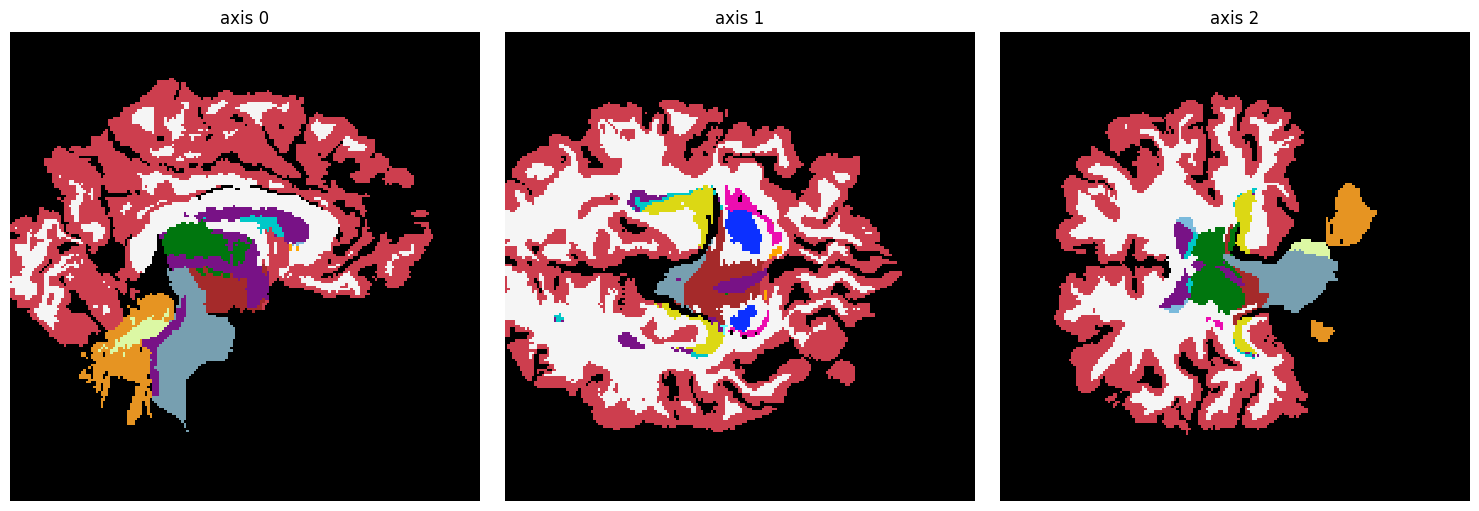

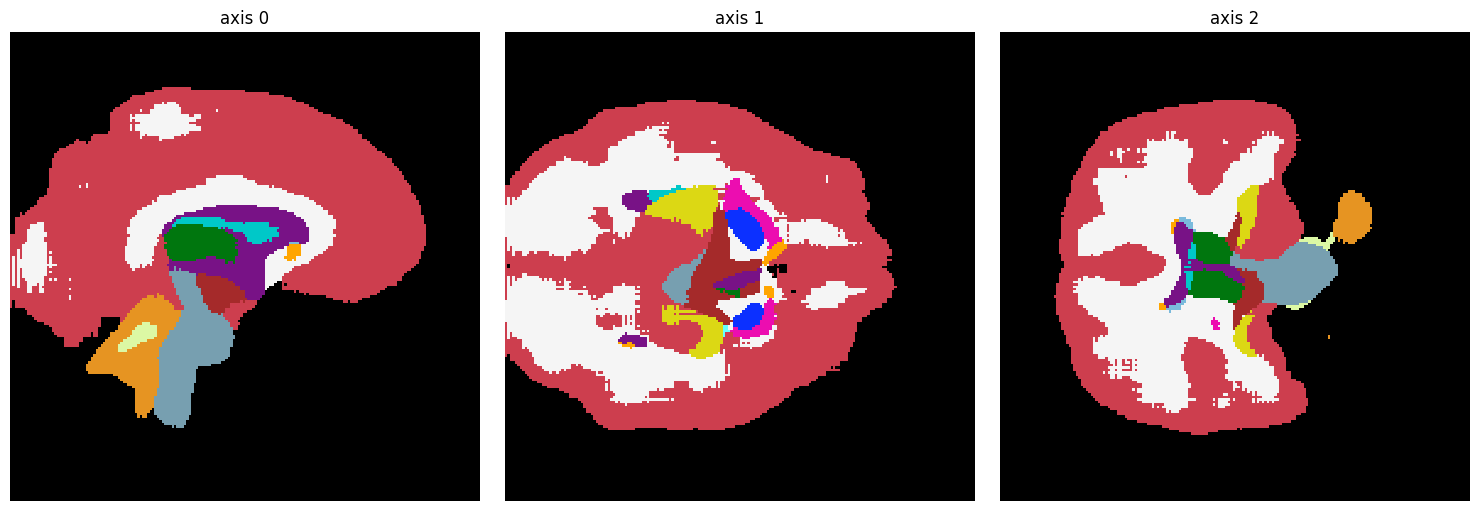

0.6742506662496633


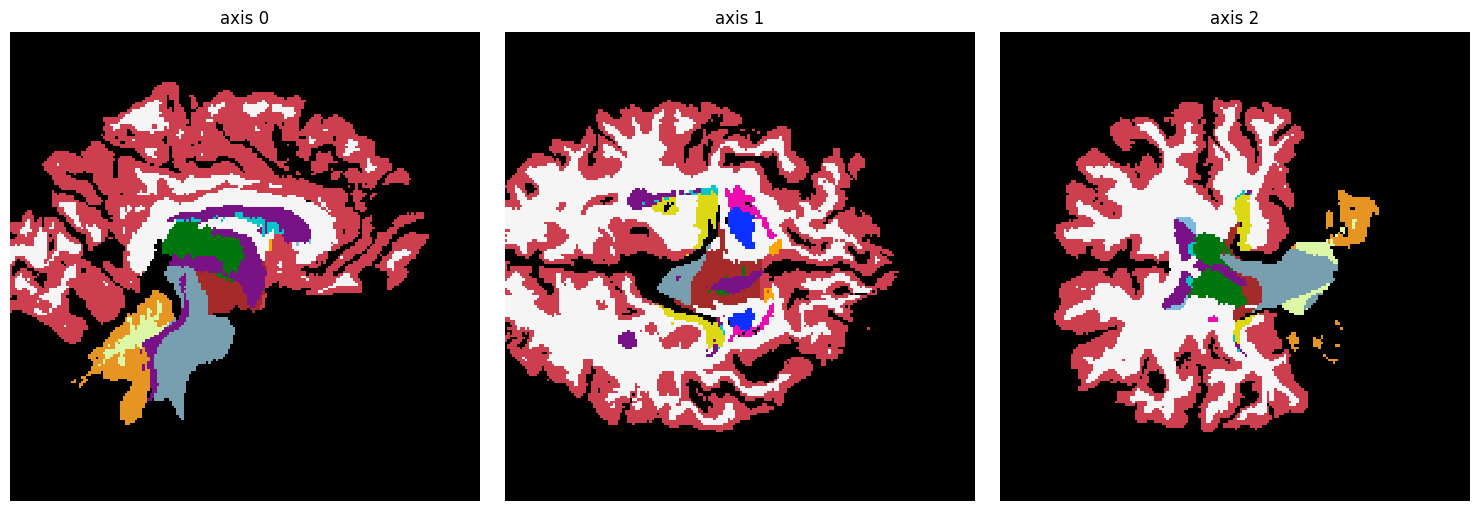

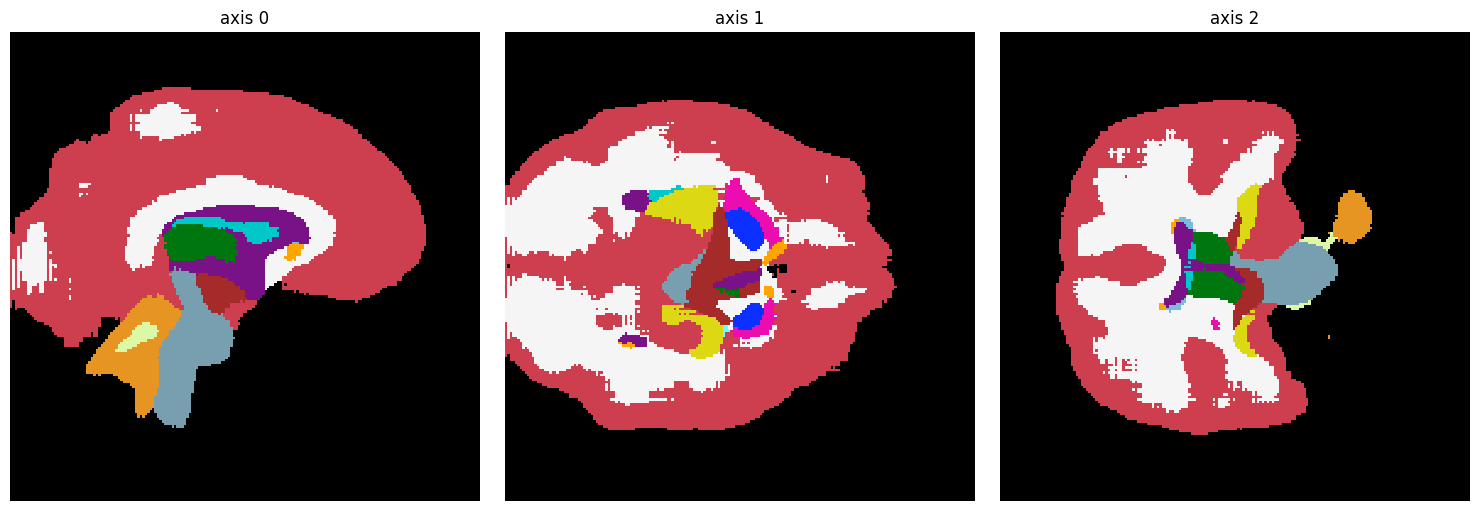

0.6994214668825074


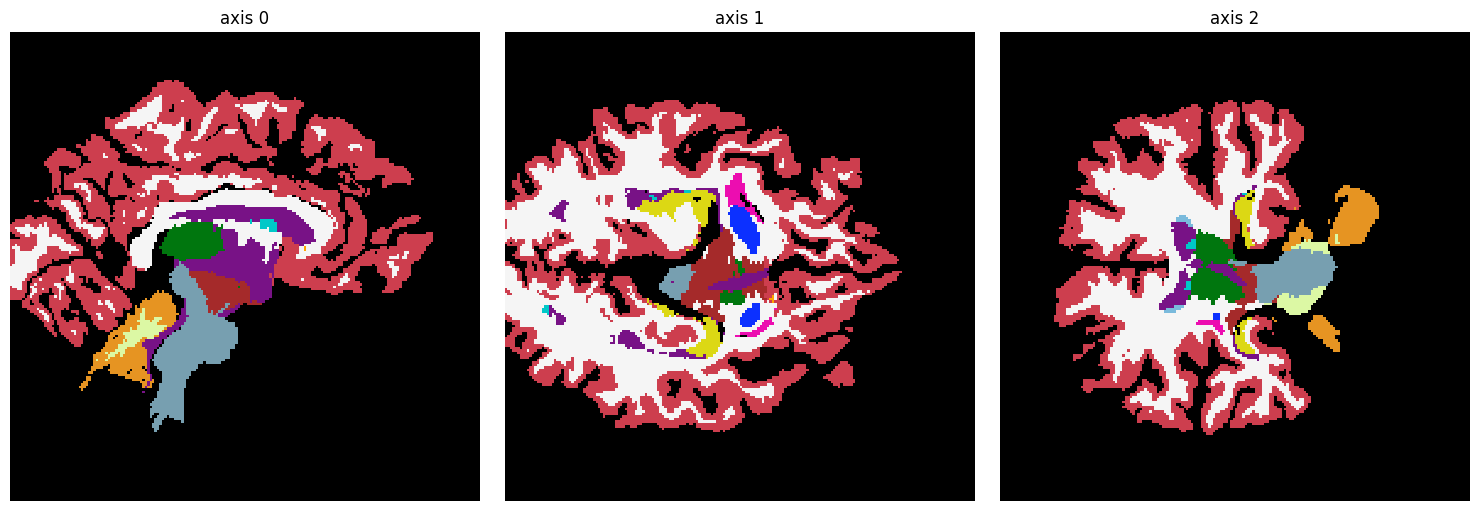

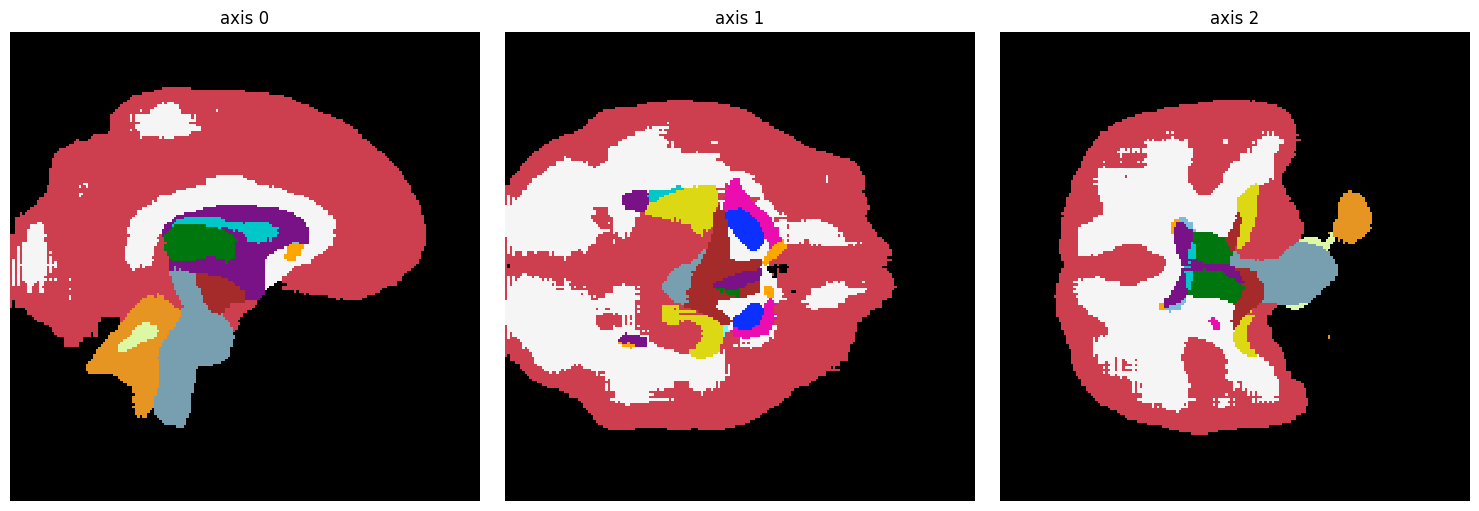

0.7468567862305088


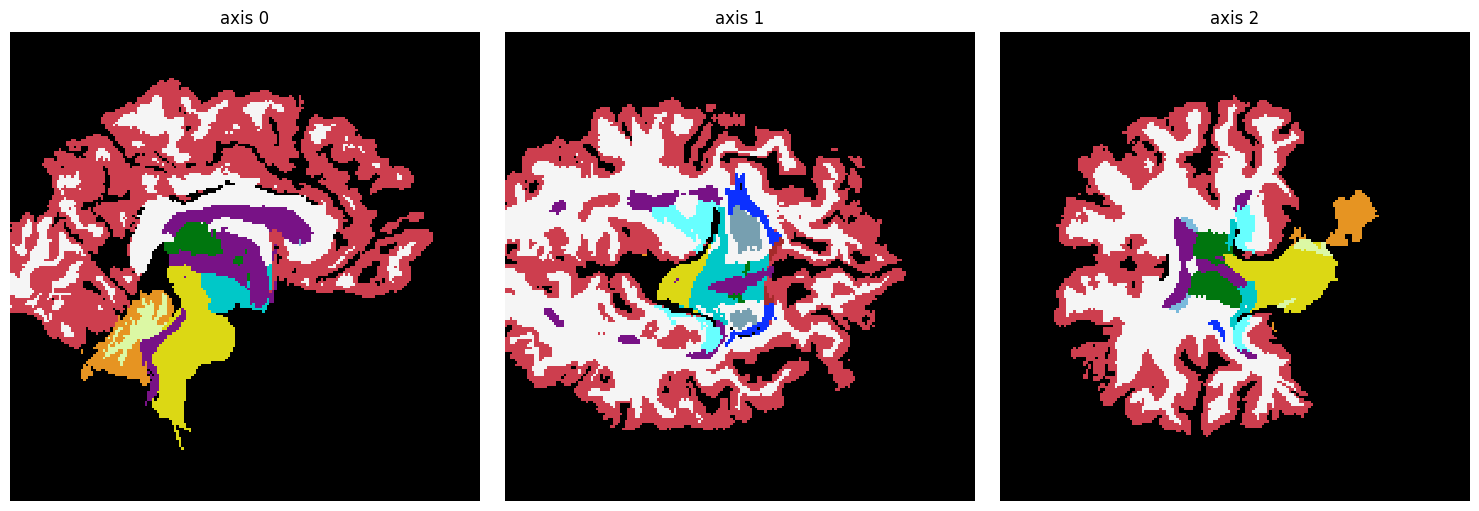

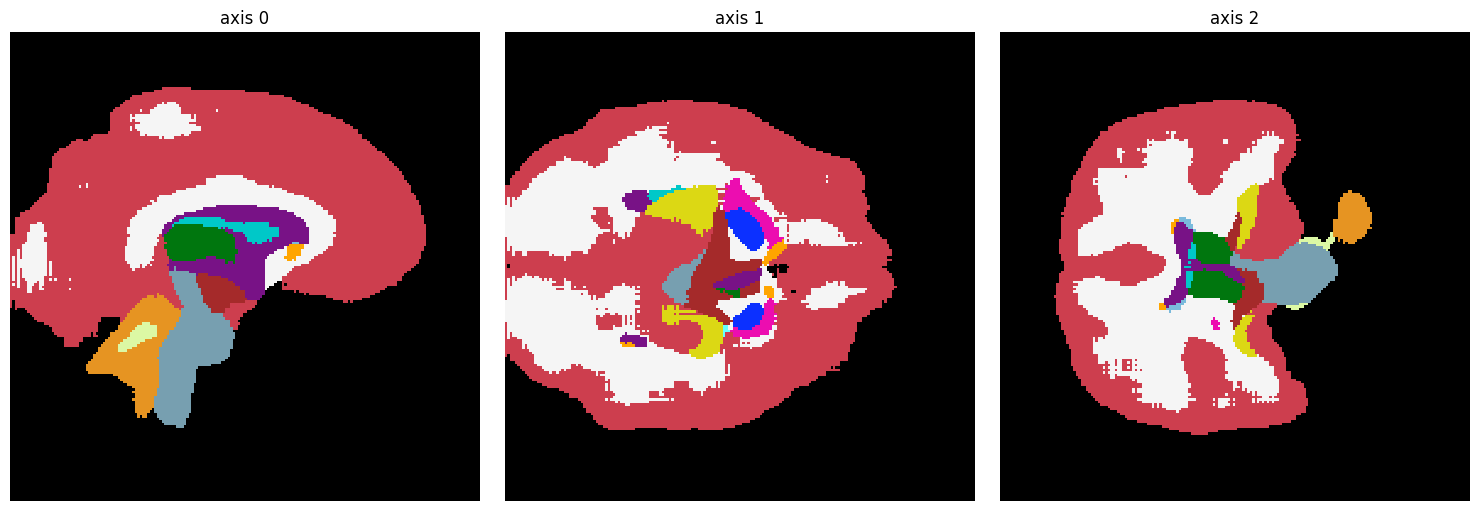

0.6994214668825074


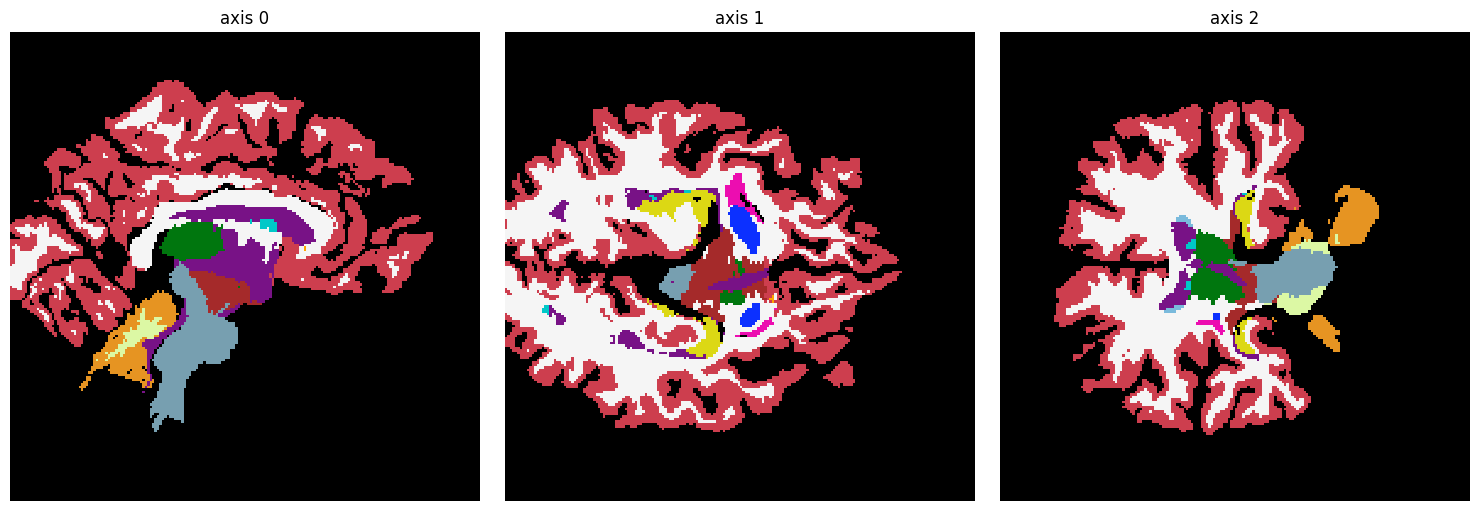

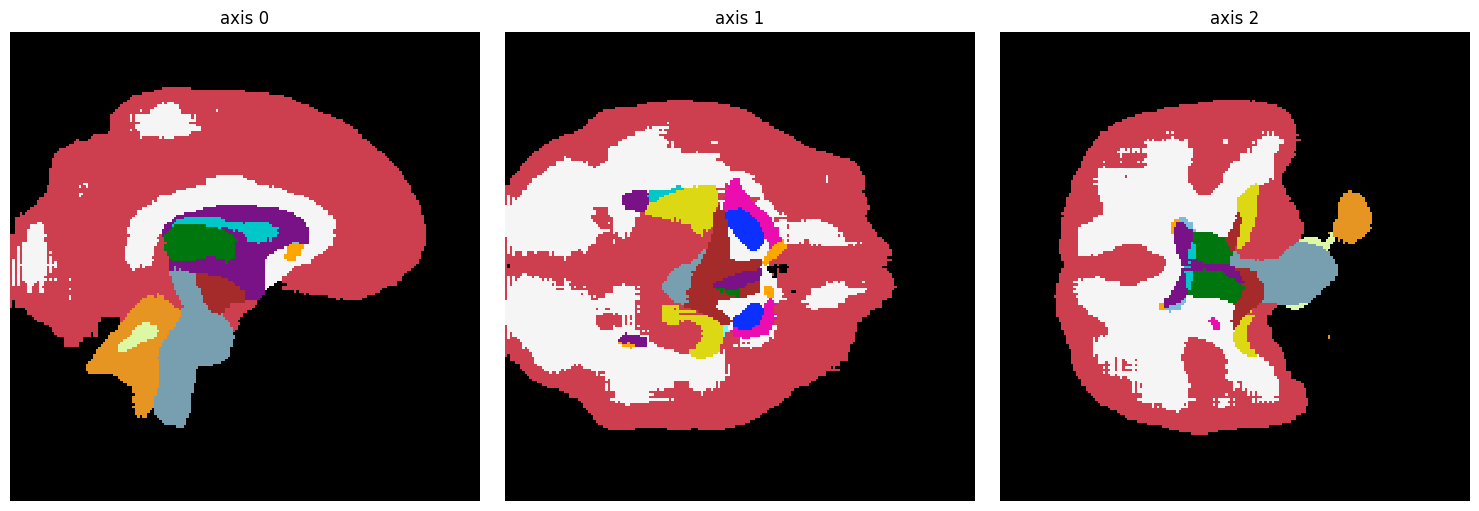

average dice: 0.6994925659135858


In [57]:
from utils import *
tseg = np.array(olist)

# def make_cmap(num_to_col=None, name='freesurfer'):
#     '''Create Matplotlib colormap and normalization from FreeSurfer LUT.'''
#     if not isinstance(num_to_col, dict):
#         _, _, num_to_col = read_lut(num_to_col)
#     import matplotlib.colors as mc
#     num_col = max(num_to_col, key=int)
#     colors = np.zeros((num_col + 1, 3))
#     for k, v in num_to_col.items():
#         colors[k, ...] = v / 255
#     cmap = mc.ListedColormap(colors, name=name)
#     norm = mc.Normalize(vmin=0, vmax=cmap.N-1)
#     return cmap, norm

# def my_nonzero_hard_dice(y_true, y_pred):
#     unique_labels = np.unique(y_true)
#     dice_scores = []
#     for label in unique_labels:
#         if label != 0:  # Exclude background label
#             y_true_label = (y_true == label).astype(int)
#             y_pred_label = (y_pred == label).astype(int)
#             dice = dice_coefficient(y_true_label, y_pred_label)
#             dice_scores.append(dice)
#     if len(dice_scores) > 0:
#         return np.mean(dice_scores)
#     else:
#         return 0.0  # If there are no non-zero labels, return 0
        
# def dice_coefficient(y_true, y_pred):
#     intersection = np.sum(y_true * y_pred)
#     union = np.sum(y_true) + np.sum(y_pred)
#     return (2.0 * intersection) / (union) 


# def read_lut(lut=None):
#     '''Read FS lookup table (LUT) from LUT, FS directory or FREESURFER_HOME.'''
#     fs = 'FREESURFER_HOME'
#     assert fs in os.environ or os.path.exists(lut)
#     if not lut:
#         lut = os.environ[fs]
#     if os.path.isdir(lut):
#         lut = os.path.join(lut, 'FreeSurferColorLUT.txt')
#     with open(lut, 'r') as f:
#         lines = f.read().splitlines()
#     lines = [l for l in (l.strip() for l in lines) if l and l[0] != '#']
#     words = [w for w in (l.split() for l in lines)]
#     num_to_name = {int(w[0]): w[1] for w in words}
#     name_to_num = {v: k for k, v in num_to_name.items()}
#     num_to_col = {int(w[0]): np.uint8(w[2:5]) for w in words}
#     return num_to_name, name_to_num, num_to_col
    
first_slice_numbers = [100,102,77]
fs_cmap, fs_norm = make_cmap('nonlat.txt') 
dice_scores = []
for i in range(num_gen):
    t = tseg[i].astype(np.int32)
    p = pseg[i].astype(np.int32)
    dice_score = my_nonzero_hard_dice(t,p)
    dice_scores.append(dice_score)
    print(dice_score)
    ne.plot.volume3D(t, cmaps=[fs_cmap],slice_nos=first_slice_numbers)
    ne.plot.volume3D(p, cmaps=[fs_cmap],slice_nos=first_slice_numbers)
print("average dice:",np.mean(dice_scores))

In [18]:
# # imgs = np.array(ilist)
# # tseg = np.array(olist)
# pseg = np.array(plist)
# # print(imgs.shape,tseg.shape,pseg.shape)
# import nibabel as nib
# import numpy as np

# # print(imgs[0].shape)
# for i in range(1):
#     # nib.save(nib.Nifti1Image(imgs[i].astype(np.float32), np.eye(4), header=None), f"output/base_image{i}.nii.gz")
#     # nib.save(nib.Nifti1Image(tseg[i].astype(np.int32), np.eye(4), header=None), f"output/base_tseg{i}.nii.gz")
#     nib.save(nib.Nifti1Image(pseg[i].astype(np.int32), np.eye(4), header=None), f"output/base_pseg{i}.nii.gz")

# # fv = fs.Freeview(swap_batch_dim=True)
# # fv.vol(imgs, name='img', opts=':locked=1:linked=1')

In [11]:
# for n in tqdm(range(1)):
#     inb, outb = next(vgen)
#     pred = model.predict(inb)
#     # d = model.evaluate(inb, outb, verbose=0)
#     d = lfunc_dice(tf.convert_to_tensor(outb, tf.float32), tf.convert_to_tensor(pred, tf.float32))
#     d = (d.numpy() * mask).sum() / mask.sum()
#     dlist.append(d)
#     print(inb[0].shape)
#     ilist.append(inb[0].squeeze().copy())
#     olist.append(np.argmax(outb[0].squeeze(), axis=-1).copy())
#     plist.append(np.argmax(pred[0].squeeze(), axis=-1).copy())


# print(f'real dice {np.array(dlist).mean()}')
# print(f'{dlist}')


  0%|          | 0/1 [00:00<?, ?it/s]

1/1 [==============================] - 134s 134s/step
(1, 192, 192, 192, 1)


100%|██████████| 1/1 [05:33<00:00, 333.72s/it]

real dice -0.8219432532787323
[-0.8219432532787323]


In [15]:
print(imgs.shape[0])

5


# Test

In [ ]:
test_mseg = True
if test_mseg:
    aseg_atlas_fname = 'aseg.fscale.1.1.h5'
    print(f'reading aseg atlas model from {aseg_atlas_fname}')
    atlas_model = tf.keras.models.load_model(aseg_atlas_fname, custom_objects=ld.layer_dict)
    mapping = fs.lookups.nonlateral_aseg_recoder()
    target_lut = mapping.target_lut
    lut_name = 'nonlat.txt'
    adir = '/autofs/cluster/freesurfer/subjects/atlases/aseg_atlas'
    mname = 'seg_edited.mgz'
    vname = 'norm.mgz'
    sfile = os.path.join(adir, 'scripts', 'subjects.txt')
    with open(sfile, 'r') as f:
        subjects = f.read().split('\n')[0:-1]

    mri_man_segs = []  # manual segs
    mri_norms = []  # mri vols
    mri_norms_orig = []
    mri_man_segs_orig = []
    for s in tqdm(subjects):
        # mri_seg_orig = fs.Volume.read(os.path.join(adir, s, 'mri', mname))
        mri_seg_orig = sf.load_volume(os.path.join(adir, s, 'mri', mname))
        mri_man_segs_orig.append(mri_seg_orig)
        # mri_seg = mri_seg_orig.fit_to_shape(target_shape, center='bbox')
        mri_seg = mri_seg_orig.reshape(target_shape)
        mri_man_segs.append(mri_seg)
        mri_norm_orig = sf.load_volume(os.path.join(adir, s, 'mri', vname))
        mri_norm = mri_norm_orig.resample_like(mri_seg)
        mri_norms.append(mri_norm)
        mri_norms_orig.append(mri_norm_orig)

    mri_man_segs_recoded = [fs.label.recode(mri, mapping) for mri in tqdm(mri_man_segs)]

    mri_seg_atlas = sf.load_volume("aseg_atlas.mgz")
    hard_seg = np.argmax(mri_seg_atlas.data, axis=-1)
    # mri_hard_seg = mri_seg_atlas.copy(hard_seg).fit_to_shape(target_shape, center='bbox')
    mri_hard_seg = sf.Volume(hard_seg).resample_like(mri_seg_atlas).reshape(target_shape)
    mri_norm_atlas = sf.load_volume("norm_atlas.mgz").resample_like(mri_hard_seg)
    mri_seg_atlas = mri_seg_atlas.resample_like(mri_hard_seg)
    norm_atlas = (mri_norm_atlas.data / mri_norm_atlas.data.max())[np.newaxis, ..., np.newaxis]

    # psize = (norm_atlas.shape[1] - mri_norms[0].shape[0]) // 2
    # pad = ((0,0), (psize,psize), (psize, psize), (psize, psize), (0, 0))
    dice_list = []
    elist = []
    elist_in_atlas = []
    alist_in_atlas = []
    nlist_in_atlas = []
    mlist_in_atlas = []
    for sno, s in enumerate(tqdm(subjects)):
        mseg_onehot = np.eye(nlabels_small)[mri_man_segs_recoded[sno].data]
        norm = (mri_norms[sno].data / mri_norms[sno].data.max())[np.newaxis, ..., np.newaxis]
        pred = model.predict(norm)
        # transform = gens.vxm_model.predict([l, norm, norm_atlas])
        vxm_model = gens.read_vxm_model(inshape)
        # smooth_wt_input = KL.Input(vxm_model.inputs[0].shape[1:])
        # print("vxm_model.inputs[0]",vxm_model.inputs[0],smooth_wt_input )
        l = np.zeros((1, 1))
        l[0,0] = .3
        #transform = vxm_model.predict([l, norm, norm_atlas])
        transform = vxm_model.predict([l, norm, norm_atlas])
        # transform = transform[:, psize:-psize, psize:-psize, psize:-psize, :]
        dice = lfunc(tf.convert_to_tensor(mseg_onehot[np.newaxis], tf.float32), 
                     tf.convert_to_tensor(pred, tf.float32))
        dice_list.append(dice.numpy())
        ev = (mseg_onehot - pred[0])
        evol = (ev**2).sum(axis=-1)
        elist.append(evol)
        evol_in_atlas = vxm.layers.SpatialTransformer(interp_method='linear', fill_value=0)([evol[np.newaxis, ..., np.newaxis], transform])
        norm_in_atlas = vxm.layers.SpatialTransformer(interp_method='linear', fill_value=0)([norm, transform])
        aseg_in_atlas = vxm.layers.SpatialTransformer(interp_method='linear', fill_value=0)([pred[0][np.newaxis, ...], transform])
        mseg_in_atlas = vxm.layers.SpatialTransformer(interp_method='linear', fill_value=0)([mseg_onehot[np.newaxis, ...], transform])
        elist_in_atlas.append(evol_in_atlas.numpy().squeeze())
        nlist_in_atlas.append(norm_in_atlas.numpy().squeeze())
        #alist_in_atlas.append(np.argmax(aseg_in_atlas.numpy(), axis=-1).squeeze())
        #mlist_in_atlas.append(np.argmax(mseg_in_atlas.numpy(), axis=-1).squeeze())
        alist_in_atlas.append(aseg_in_atlas.numpy().squeeze())
        mlist_in_atlas.append(mseg_in_atlas.numpy().squeeze())

    evol_avg = np.array(elist_in_atlas).mean(axis=0)
    nvol_avg = np.array(nlist_in_atlas).mean(axis=0)
    nbhd_img = scipy.ndimage.convolve(evol_avg, np.ones((patch_size,)*3)/(patch_size**3), mode='constant')
    mseg_avg = np.argmax(np.array(mlist_in_atlas).mean(axis=0), axis=-1)
    aseg_avg = np.argmax(np.array(alist_in_atlas).mean(axis=0), axis=-1)
    max_ind = np.argmax(nbhd_img)
    print('computing index occurence volumes')
    aseg_inds = np.argmax(np.array(alist_in_atlas), axis=-1)
    mseg_inds = np.argmax(np.array(mlist_in_atlas), axis=-1)
    max_inds = 10
    mseg_ind_vol = np.zeros(target_shape + (max_inds,))
    aseg_ind_vol = np.zeros(target_shape + (max_inds,))
    mseg_num_inds = np.zeros(target_shape)
    aseg_num_inds = np.zeros(target_shape)
    for x in tqdm(range(aseg_inds.shape[1])):
        for y in range(aseg_inds.shape[2]):
            for z in range(aseg_inds.shape[3]):
                ind_list = -1 * np.ones((max_inds,))
                u = np.unique(mseg_inds[:, x, y, z])
                for lno, l in enumerate(u):
                    if lno >= max_ind:
                        break
                    mseg_ind_vol[x, y, z, lno] = l
                
                mseg_num_inds[x, y, z] = len(u)
                ind_list = -1 * np.ones((max_inds,))
                u = np.unique(aseg_inds[:, x, y, z])
                for lno, l in enumerate(u):
                    aseg_ind_vol[x, y, z, lno] = l

                aseg_num_inds[x, y, z] = len(u)

    subs = np.unravel_index(max_ind, nbhd_img.shape)
    labels_mseg = np.unique(np.argmax(np.array(mlist_in_atlas), axis=-1)[:, subs[0], subs[1], subs[2]])
    labels_aseg = np.unique(np.argmax(np.array(alist_in_atlas), axis=-1)[:, subs[0], subs[1], subs[2]])
    print(subs)

# fv = fs.Fre
    # fv = fs.Freeview()
    # fv.vol(mri_segs[0].copy(nvol_avg), name='norm avg')
    # fv.vol(mri_segs[0].copy(mseg_avg), name='mseg', opts=':colormap=lut:lut=nonlat')
    # fv.vol(mri_segs[0].copy(aseg_avg), name='aseg', opts=':colormap=lut:lut=nonlat')
    # nvols = 3
    # mvols = np.argmax(np.array(mlist_in_atlas[0:nvols]), axis=-1)
    # avols = np.argmax(np.array(alist_in_atlas[0:nvols]), axis=-1)
    # fv.vol(mri_segs[0].copy(np.transpose(np.array(nlist_in_atlas[0:nvols]), (1, 2, 3, 0))), name='norm vols')
    # fv.vol(mri_segs[0].copy(np.transpose(mvols, (1, 2, 3, 0))), name='man segs', opts=':colormap=lut:lut=nonlat')
    # fv.vol(mri_segs[0].copy(np.transpose(avols, (1, 2, 3, 0))), name='synth segs', opts=':colormap=lut:lut=nonlat')
    # fv.vol(mri_segs[0].copy(nbhd_img), name='err avg', opts=':colormap=heat:heatscale=.25,.5')
    # fv.show(opts=f'-slice {subs[0]} {subs[1]} {subs[2]}', verbose=True)


reading aseg atlas model from aseg.fscale.1.1.h5


  0%|          | 0/41 [00:00<?, ?it/s]

1/1 [==============================] - 155s 155s/step


  2%|▏         | 1/41 [05:03<3:22:24, 303.60s/it]

1/1 [==============================] - 164s 164s/step


  5%|▍         | 2/41 [10:12<3:19:26, 306.82s/it]

1/1 [==============================] - 164s 164s/step


  7%|▋         | 3/41 [15:28<3:17:01, 311.08s/it]

1/1 [==============================] - 164s 164s/step


 10%|▉         | 4/41 [20:46<3:13:19, 313.50s/it]

1/1 [==============================] - 162s 162s/step


 12%|█▏        | 5/41 [25:55<3:07:14, 312.08s/it]

1/1 [==============================] - 165s 165s/step


 15%|█▍        | 6/41 [31:11<3:02:47, 313.37s/it]

1/1 [==============================] - 169s 169s/step


 17%|█▋        | 7/41 [36:30<2:58:36, 315.18s/it]

1/1 [==============================] - 165s 165s/step


 20%|█▉        | 8/41 [41:45<2:53:22, 315.22s/it]

1/1 [==============================] - 170s 170s/step


 22%|██▏       | 9/41 [47:05<2:48:55, 316.72s/it]

1/1 [==============================] - 164s 164s/step


 24%|██▍       | 10/41 [52:18<2:43:05, 315.65s/it]

1/1 [==============================] - 113s 113s/step


In [16]:
mri_hard_seg = sf.Volume(hard_seg).resample_like(mri_seg_atlas).reshape(target_shape)



In [ ]:
print(imgs[0].shape)
nvols = 3
mvols = np.argmax(np.array(mlist_in_atlas[0:nvols]), axis=-1)
avols = np.argmax(np.array(alist_in_atlas[0:nvols]), axis=-1)
volume_data = mri_segs[0].copy(np.transpose(np.array(nlist_in_atlas[0:nvols]), (1, 2, 3, 0))).astype(np.int32)
nib.save(nib.Nifti1Image(volume_data, np.eye(4), header=None), "output/nvol_avg.nii.gz")

# nib.save(nib.Nifti1Image(mri_segs[0].copy(np.transpose(np.array(nlist_in_atlas[0:nvols]), (1, 2, 3, 0))).astype(np.int32), np.eye(4), header=None), "output/nvol_avg.nii.gz")

# nib.save(nib.Nifti1Image(tseg[i].astype(np.int32), np.eye(4), header=None), f"output/tseg{i}.nii.gz")
# nib.save(nib.Nifti1Image(pseg[i].astype(np.int32), np.eye(4), header=None), f"output/pseg{i}.nii.gz")
    # for i in range(imgs.shape[0]):
        # nib.save(nib.Nifti1Image(imgs[i].astype(np.int32), np.eye(4), header=None), f"output/nvol_avg.nii.gz")
        # nib.save(nib.Nifti1Image(tseg[i].astype(np.int32), np.eye(4), header=None), f"output/tseg{i}.nii.gz")
        # nib.save(nib.Nifti1Image(pseg[i].astype(np.int32), np.eye(4), header=None), f"output/pseg{i}.nii.gz")
